#### Testing classes for furry-couscous

In [1]:
from fcc_DRs import * # file with dimensionality reduction classes

Using TensorFlow backend.


In [2]:
# read a csv file into a counts_file object
# this one has cells already in the rows, but no cell ID labels
# it does have gene labels in the 0th row position
test1 = counts_file(datafile='inputs/Myeloid_with_IDs.csv', labels=[None,0], cells_axis=0)

In [3]:
# this is already feature-selected to 171 genes
test1.data.shape

(4423, 171)

In [4]:
# this object has a bunch of useful attributes:
test1.data # gives the full data as pd.DataFrame, including cell and gene IDs if available
test1.counts # gives the counts matrix as a np.array
test1.filetype # stores filetype of original input
test1.gene_IDs # this particular dataset has gene IDs

Index(['1100001G20RIK', '1190002H23RIK', '1190007F08RIK', '2210020M01RIK',
       '3110082D06RIK', 'AK084954', 'IGHG1', 'ADSSL1', 'ALAD', 'ALAS1',
       ...
       'TMSB4X', 'TNFAIP2', 'TNNI3', 'TREM3', 'TSPO', 'TYROBP', 'UQCRH',
       'VAMP5', 'VIM', 'ZFPM1'],
      dtype='object', length=171)

In [5]:
# we can take a subset of the cells in our dataframe for quicker analysis
test1.random_subset(n_cells=500)
test1.subset.shape

(500, 171)

In [6]:
# similarly, we can generate K-fold splits of the original data to train and test DR algorithms
test1.kfold_split(n_splits=4, seed=18) # let's do a 4-fold cross-validation model

In [11]:
# now we should have K different subsets of the data (testing sets) with K corresponding training sets
# each 'test' set should be of length round(n_cells/K, 0)
print('Testing set 0 size: ',test1.splits['test'][0].shape)
print('Training set 0 size: ',test1.splits['train'][0].shape)

Testing set 0 size:  (1106, 171)
Training set 0 size:  (3317, 171)


In [13]:
# in order to manipulate any of these subsets, we can generate a new RNA_counts object
test1_1 = RNA_counts(data=test1.splits['test'][2]) # here, let's take the third testing set of data to play with

print(test1_1.data.shape) # new object has same dimensions as previous subset
print(test1_1.cell_IDs) # random cell IDs made it into the new object

(1106, 171)
Int64Index([   4,    8,    9,   12,   14,   15,   16,   17,   23,   25,
            ...
            4383, 4391, 4393, 4398, 4405, 4406, 4408, 4411, 4412, 4414],
           dtype='int64', length=1106)


In [14]:
# now any manipulations of the counts attribute will be using 500 randomly subsetted cells
# generate PCA object for arcsinh-transformed data with 100 components
%time test1_1_PCA = fcc_PCA(test1_1.arcsinh_norm(norm=True, scale=1000), n_components=100)

CPU times: user 313 ms, sys: 45.2 ms, total: 358 ms
Wall time: 236 ms


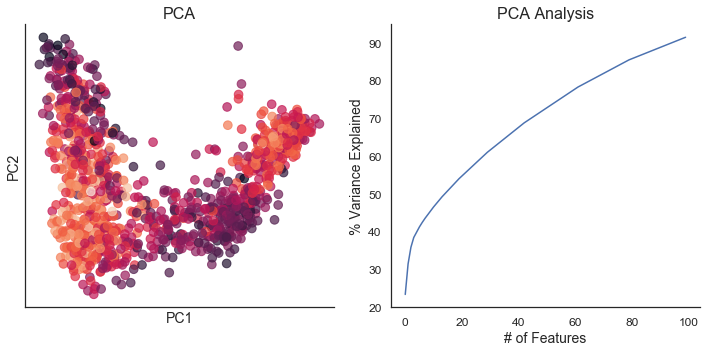

In [15]:
# look at the results
test1_1_PCA.plot()
# plots are colored by point density in 2D space

In [16]:
# now we can perform a t-SNE on the arcsinh-transformed data...
%time test1_1_tSNE = fcc_tSNE(test1_1.arcsinh_norm(norm=True, scale=1000), perplexity=30)

CPU times: user 7.56 s, sys: 283 ms, total: 7.84 s
Wall time: 7.92 s


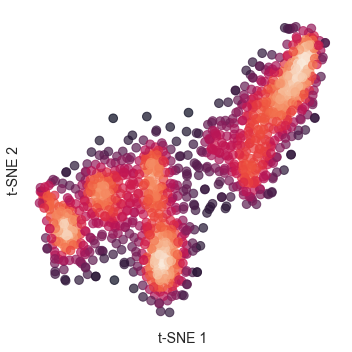

In [17]:
# ... and look at those results
test1_1_tSNE.plot()

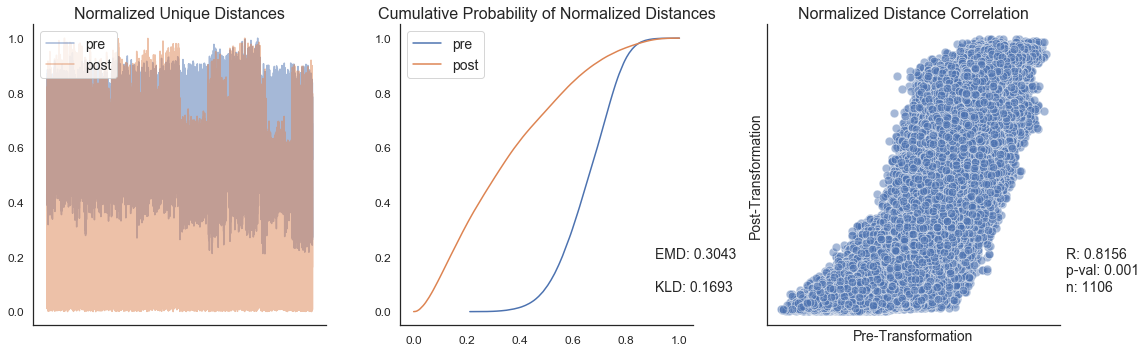

CPU times: user 30.6 s, sys: 4.41 s, total: 35 s
Wall time: 34.6 s


In [18]:
# each of these DR (dimensionality reduction) objects we've created has a .distance_matrix() method
# we can correlate the Euclidean distances pretty easily:
from fcc_utils import compare_euclid
# let's use another function I wrote to quickly perform statistical tests on the cell-cell distances
%time mantel_stats, EMD, KLD = compare_euclid(pre=test1_1_PCA.distance_matrix(), post=test1_1_tSNE.distance_matrix())

This t-SNE is primed with a PCA with 100 components


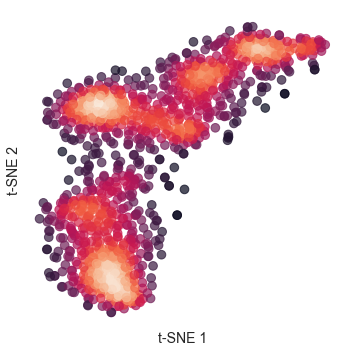

CPU times: user 7.85 s, sys: 326 ms, total: 8.17 s
Wall time: 8.06 s


In [20]:
%%time
# we could also create a tSNE primed with our PCA results just as easily with the .results attribute of the PCA object
test1_1_PCA_tSNE = fcc_tSNE(test1_1_PCA.results, perplexity=30)
# to check how many components we used in the original PCA, just call the object's attribute
print('This t-SNE is primed with a PCA with {} components'.format(test1_1_PCA.components))
test1_1_PCA_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12b802e48>)

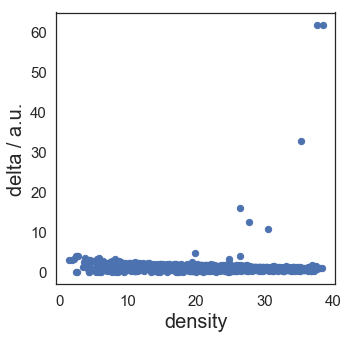

In [21]:
# density-peak clustering is built into the DR objects
# we can look at the decision graph and assign cluster centers 
test1_1_PCA_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10ac41b38>)

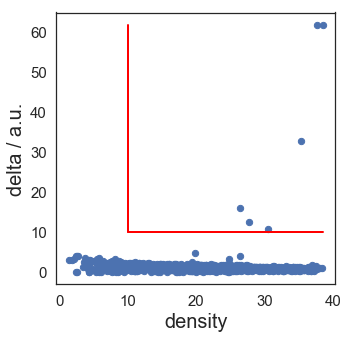

In [22]:
# now, if we assign cutoffs for density and delta, we can generate cluster membership for our tSNE
test1_1_PCA_tSNE.clu.assign(10,10)
test1_1_PCA_tSNE.clu.draw_decision_graph(min_delta=test1_1_PCA_tSNE.clu.min_delta, min_density=test1_1_PCA_tSNE.clu.min_density)

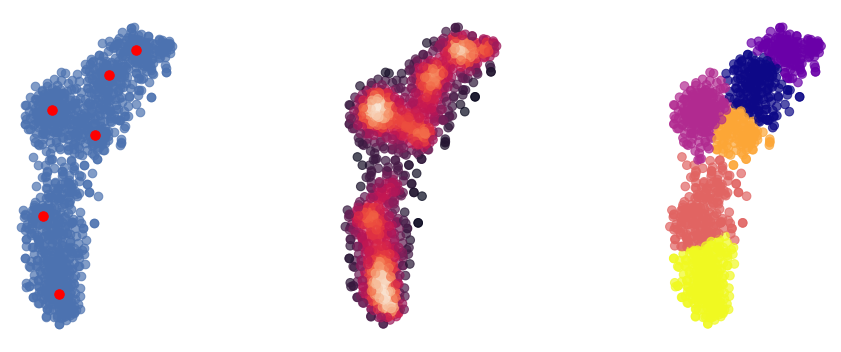

In [23]:
# finally, we can look at the clusters in our tSNE
test1_1_PCA_tSNE.plot_clusters()

In [24]:
# silhouette score is automatically calculated as well
test1_1_PCA_tSNE.silhouette_score

0.45462716

In [25]:
# this object has cluster membership for each cell built in now:
test1_1_PCA_tSNE.clu.membership

array([2, 0, 1, ..., 5, 2, 2], dtype=int32)

Clustering not yet determined. Assign clusters with self.clu.assign().
 'Cluster' object has no attribute 'clusters'


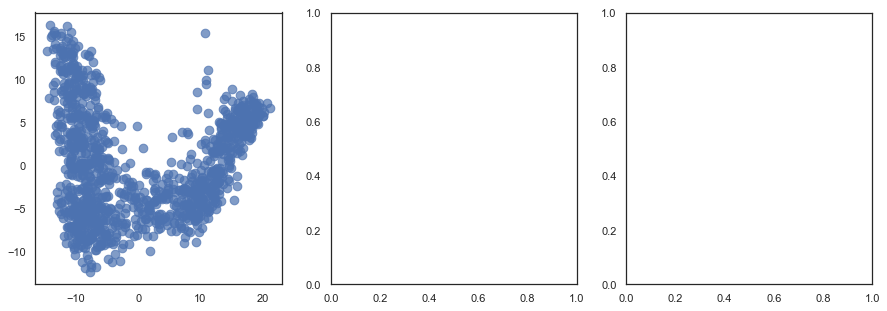

In [26]:
# if you try to plot clusters without assigning cutoffs, it won't work
# let's try with the original PCA object, which we have not clustered yet:
test1_1_PCA.plot_clusters()